# DESeq1
# Phase 1 vs. Phase 2

focusing on pairwise comparisons of oysters that only experienced phase 1 to oysters that experienced phase 2 - **how does gene expression change after a second, later environment**

## 0. load libraries

In [3]:
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)
library(vegan)

## 1. read counts matrix and meta data

### counts matrix

In [23]:
# counts matrix
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')

# set gene_ID as row name
rownames(counts) <- counts$Gene_ID

# remove gene id and length
counts.df <- counts %>%
select(-Gene_ID, -Length)

head(counts.df)

,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,2,1,6,10,9,16,0,10,22,9,⋯,9,2,8,5,2,19,1,2,1,0
LOC111126949,885,652,477,654,586,523,392,357,496,540,⋯,407,740,707,406,418,424,492,330,281,599
LOC111110729,64,209,93,63,100,177,76,98,235,181,⋯,70,149,121,115,126,108,118,115,127,213
LOC111112434,11,7,2,0,2,2,12,15,10,36,⋯,11,6,4,0,2,16,22,0,8,0
LOC111120752,360,586,336,426,351,417,236,278,761,373,⋯,359,345,438,278,287,416,621,251,333,430
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


### meta data
the meta data csv was already generated in [deseq_p1.v.p1](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/deseq_p1.v.p1.ipynb), so just reading in here

In [32]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
filter(Sample != 'B3_Nu_O24') # remove failed QC sample

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

head(meta)

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1
B1_Nu_O03,both,warm,hypoxic,1,NA,NA,NA,NA
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5
B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5
B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4
B2_Nu_O12,both,warm,hypoxic,2,NA,NA,NA,NA


creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [33]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

# check
head(meta,2)
tail(meta,2)

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1,both both
B1_Nu_O03,both,warm,hypoxic,1,NA,NA,NA,NA,both NA


,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
W6_W3_G36,warm,warm,normoxic,6,warm,warm,normoxic,3,warm warm
W6_W4_G48,warm,warm,normoxic,6,warm,warm,normoxic,4,warm warm


In [34]:
# setting the same order for counts matrix and meta data
counts.df <- counts.df[,rownames(meta)]
all(rownames(meta) == colnames(counts.df))

[1] TRUE

## 2. DESeq2
analyzing differential gene expression with [`DESeq2`](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

#### contrasts
setting up contrasts (telling DESeq what is the control treatment)

In [28]:
# tempature treatments
meta$Phase1_temp <- factor(meta$Phase1_temp,
                                   levels = c('ambient', 'warm'))

meta$Phase2_temp <- factor(meta$Phase2_temp,
                                   levels = c('ambient', 'warm'))

In [29]:
# DO treatments
meta$Phase1_DO <- factor(meta$Phase1_DO,
                                   levels = c('normoxic', 'hypoxic'))

meta$Phase2_DO <- factor(meta$Phase2_DO,
                                   levels = c('normoxic', 'hypoxic'))

### complete treatments
starting simple with looking at phase 1 treatments (not splitting into temperature/DO, just looking at combination of treatments)

In [36]:
# creating DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = counts.df,
                              colData = meta,
                              design = ~ complete_trtmt)
dds

# running DESeq
dds <- DESeq(dds)

# list coefficients
resultsNames(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 38838 119 
metadata(1): version
assays(1): counts
rownames(38838): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(119): B1_B1_O01 B1_Nu_O03 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and t

[1] "Intercept"                                  
 [2] "complete_trtmt_both.control_vs_both.both"   
 [3] "complete_trtmt_both.hypoxic_vs_both.both"   
 [4] "complete_trtmt_both.NA_vs_both.both"        
 [5] "complete_trtmt_both.warm_vs_both.both"      
 [6] "complete_trtmt_control.both_vs_both.both"   
 [7] "complete_trtmt_control.control_vs_both.both"
 [8] "complete_trtmt_control.hypoxic_vs_both.both"
 [9] "complete_trtmt_control.NA_vs_both.both"     
[10] "complete_trtmt_control.warm_vs_both.both"   
[11] "complete_trtmt_hypoxic.both_vs_both.both"   
[12] "complete_trtmt_hypoxic.control_vs_both.both"
[13] "complete_trtmt_hypoxic.hypoxic_vs_both.both"
[14] "complete_trtmt_hypoxic.NA_vs_both.both"     
[15] "complete_trtmt_hypoxic.warm_vs_both.both"   
[16] "complete_trtmt_warm.both_vs_both.both"      
[17] "complete_trtmt_warm.control_vs_both.both"   
[18] "complete_trtmt_warm.hypoxic_vs_both.both"   
[19] "complete_trtmt_warm.NA_vs_both.both"        
[20] "complete_trtmt_warm.warm_vs_both.both"

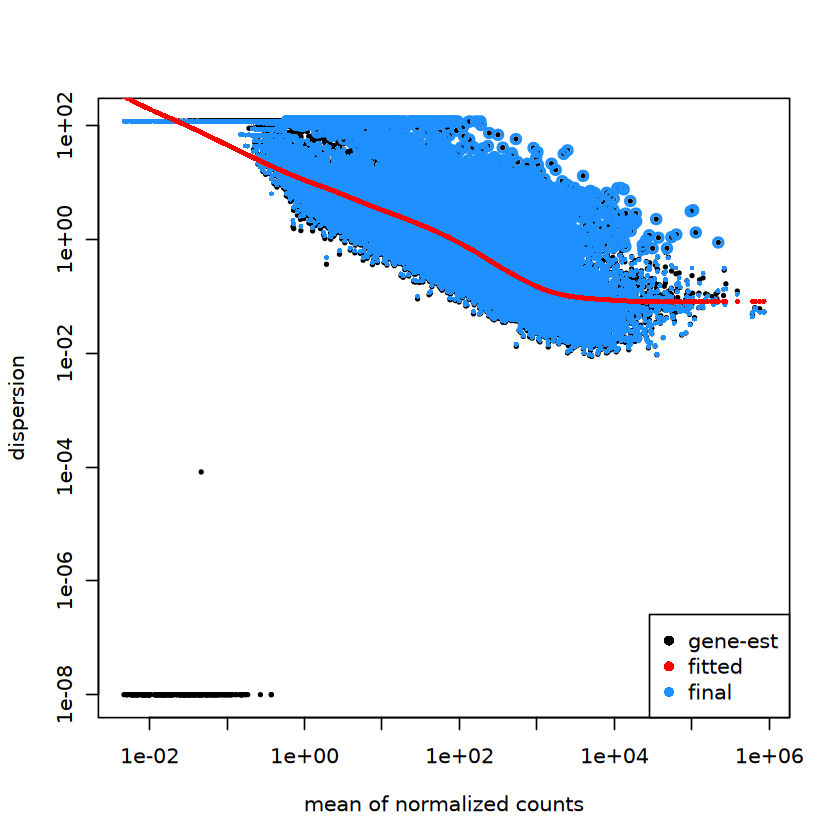

In [37]:
plotDispEsts(dds)

## nMDS
normalize and transform DESeq object using csv (variance stabilized expression matrix)

In [66]:
# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
B1_B1_O01,0.00000,79.16919,80.51911,82.23845,77.10729,95.45248,82.83342,81.58423,88.55024,82.46145,⋯,68.81028,74.88539,72.33222,75.43436,90.36162,77.64944,81.16800,82.97670,74.49760,93.87876
B1_Nu_O03,79.16919,0.00000,77.54264,85.03813,78.22327,93.51919,83.95933,84.73143,87.09834,82.74833,⋯,79.93731,79.73823,76.23154,78.64308,98.94692,78.09569,73.17994,79.04401,76.71841,93.67780
B1_W5_O50,80.51911,77.54264,0.00000,77.46482,66.60198,82.29687,66.27092,69.85036,72.56475,81.04706,⋯,79.09622,79.92782,79.75453,79.11417,83.39164,79.35388,79.46532,70.18538,74.16827,78.75929
B2_B5_O51,82.23845,85.03813,77.46482,0.00000,83.21309,86.66862,79.50580,84.14870,80.62907,89.38044,⋯,86.56631,75.21569,84.78856,87.74239,86.54078,87.96930,90.66741,85.99186,83.37719,79.22711
B2_C4_O40,77.10729,78.22327,66.60198,83.21309,0.00000,86.65126,71.93124,69.23865,78.24759,79.46459,⋯,77.01599,77.90905,76.19444,76.37689,88.55989,75.55447,75.93730,68.98067,59.85546,84.44906
B2_Nu_O12,95.45248,93.51919,82.29687,86.66862,86.65126,0.00000,82.03994,94.09058,79.53603,96.90760,⋯,99.30412,95.68246,97.71544,96.42657,74.52568,100.00754,95.67724,82.03521,89.09650,71.52940


,X1,X2,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt,sizeFactor
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<fct>,<dbl>
B1_B1_O01,-15.024131,-7.38303614,both,warm,hypoxic,1,both,warm,hypoxic,1,both both,1.0218814
B1_Nu_O03,-14.791801,0.22985572,both,warm,hypoxic,1,NA,NA,NA,NA,both NA,1.4706278
B1_W5_O50,5.125626,9.21855663,both,warm,hypoxic,1,warm,warm,normoxic,5,both warm,0.9602439
B2_B5_O51,14.316046,-0.09938081,both,warm,hypoxic,2,both,warm,hypoxic,5,both both,1.0125321
B2_C4_O40,-4.811003,5.29248160,both,warm,hypoxic,2,control,ambient,normoxic,4,both control,1.0997806
B2_Nu_O12,35.567200,23.77506004,both,warm,hypoxic,2,NA,NA,NA,NA,both NA,1.2976250


Warning message:
“Removed 23 rows containing missing values or values outside the scale range
(`geom_point()`).”


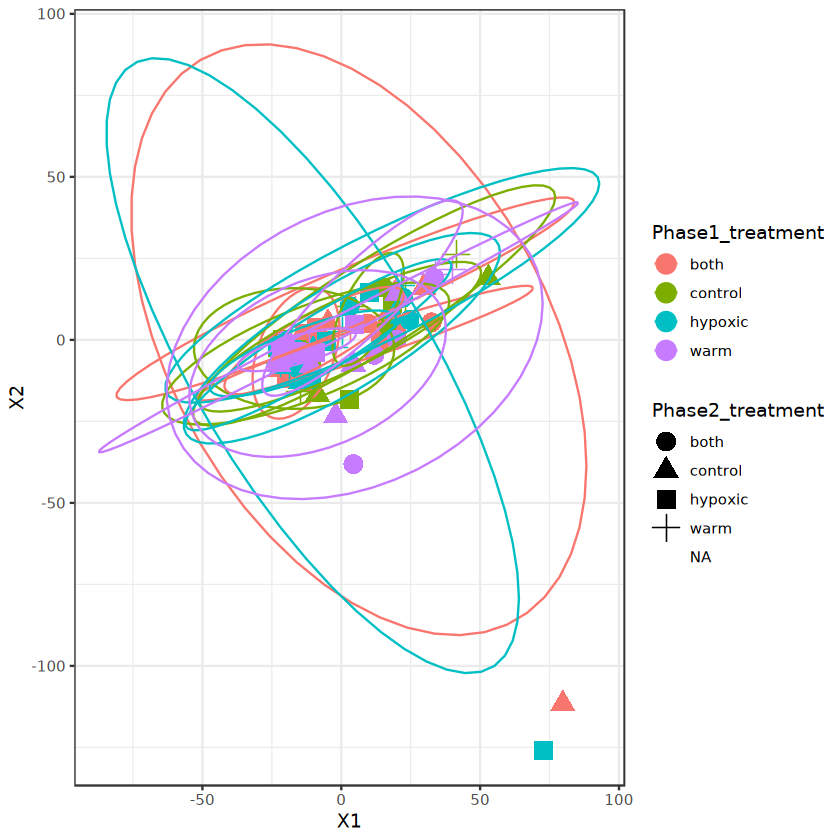

In [68]:
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_treatment, shape = Phase2_treatment)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw()

nmds.plot

well this is a mess and not informative at all ... was curious if samples that shared a phase 1 clustered together

## 2.a. Single Stressors

### 2.a.1. early stressor when returned to control conditions

#### W vs. WC

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35466 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 657, 1.9%
LFC < 0 (down)     : 590, 1.7%
outliers [1]       : 877, 2.5%
low counts [2]     : 1369, 3.9%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



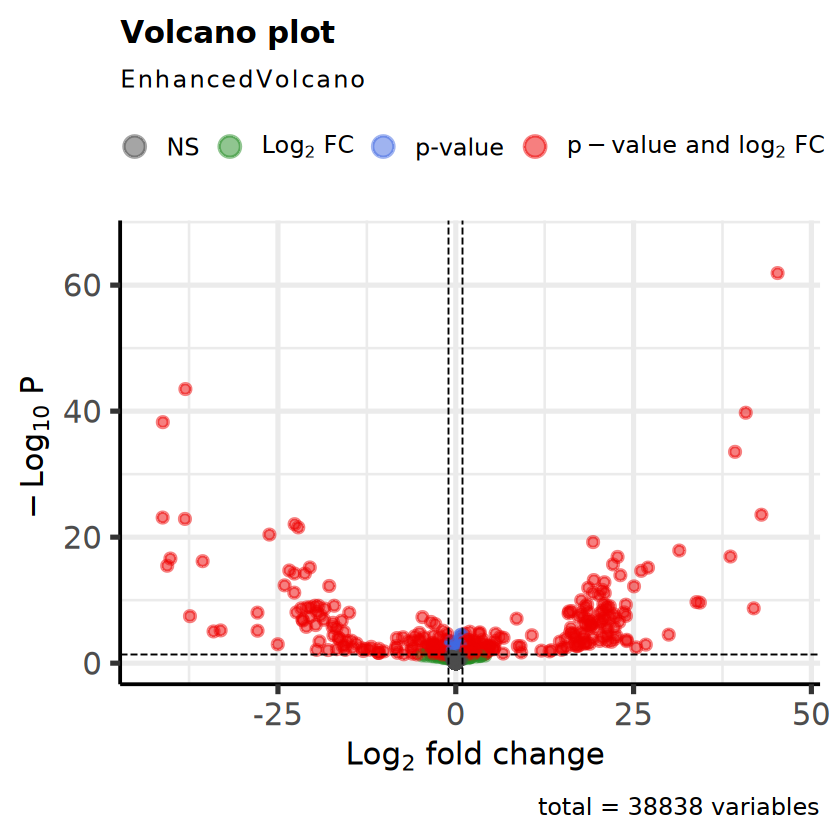

In [47]:
# W (set as control) vs. WC
res.w.wc.LFC <- lfcShrink(dds, 
                         contrast=c('complete_trtmt', 'warm.control', 'warm.NA'), 
                         type = 'ashr')

summary(res.w.wc.LFC)

EnhancedVolcano(res.w.wc.LFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [48]:
write.csv(res.w.wc.LFC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase2/deseq_res_files/p1.warm_v_p2.warm.cont.csv')

#### H vs. HC

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35466 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1776, 5%
LFC < 0 (down)     : 2389, 6.7%
outliers [1]       : 877, 2.5%
low counts [2]     : 2703, 7.6%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



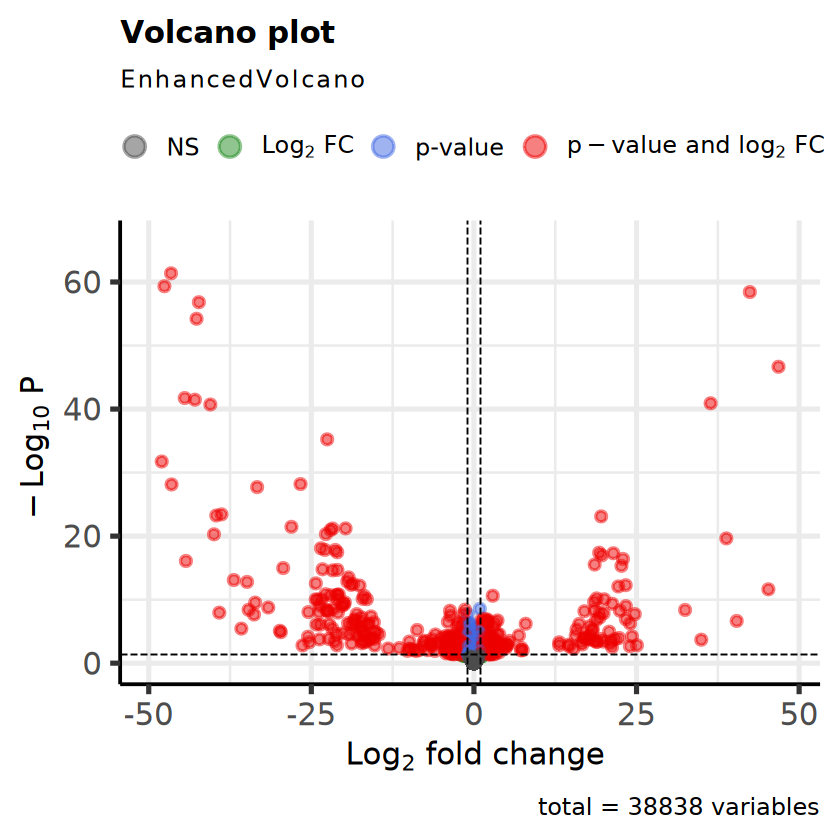

In [49]:
# H (set as control) vs. HC
res.h.hc.LFC <- lfcShrink(dds, 
                         contrast=c('complete_trtmt', 'hypoxic.control', 'hypoxic.NA'), 
                         type = 'ashr')

summary(res.h.hc.LFC)

EnhancedVolcano(res.h.hc.LFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [50]:
write.csv(res.h.hc.LFC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase2/deseq_res_files/p1.hyp_v_p2.hyp.cont.csv')

### 2.a.2. early stressor in continued exposure

#### W vs. WW

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35466 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 498, 1.4%
LFC < 0 (down)     : 465, 1.3%
outliers [1]       : 877, 2.5%
low counts [2]     : 685, 1.9%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



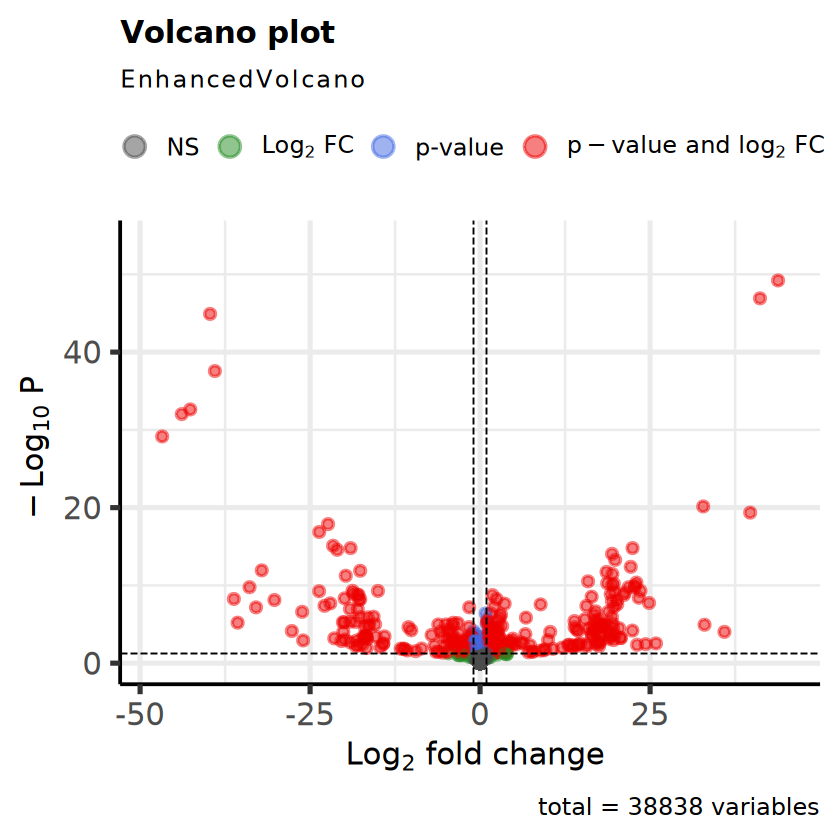

In [51]:
# W (set as control) vs. WW
res.w.ww.LFC <- lfcShrink(dds, 
                         contrast=c('complete_trtmt', 'warm.warm', 'warm.NA'), 
                         type = 'ashr')

summary(res.w.ww.LFC)

EnhancedVolcano(res.w.ww.LFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [52]:
write.csv(res.w.ww.LFC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase2/deseq_res_files/p1.warm_v_p2.warm.warm.csv')

#### H vs. HH

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35466 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2489, 7%
LFC < 0 (down)     : 1977, 5.6%
outliers [1]       : 877, 2.5%
low counts [2]     : 2047, 5.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



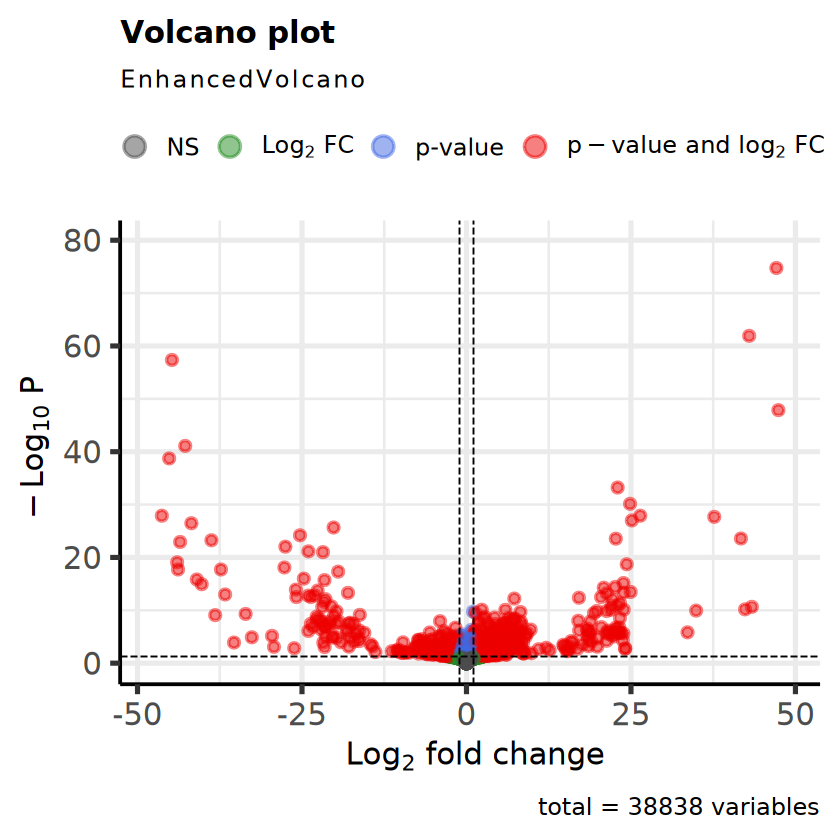

In [53]:
# H (set as control) vs. HH
res.h.hh.LFC <- lfcShrink(dds, 
                         contrast=c('complete_trtmt', 'hypoxic.hypoxic', 'hypoxic.NA'), 
                         type = 'ashr')

summary(res.h.hh.LFC)

EnhancedVolcano(res.h.hh.LFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [54]:
write.csv(res.h.hh.LFC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase2/deseq_res_files/p1.hyp_v_p2.hyp.hyp.csv')

### 2.a.3. timing of experienced stress

#### W vs. CW

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35466 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 528, 1.5%
LFC < 0 (down)     : 414, 1.2%
outliers [1]       : 877, 2.5%
low counts [2]     : 685, 1.9%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



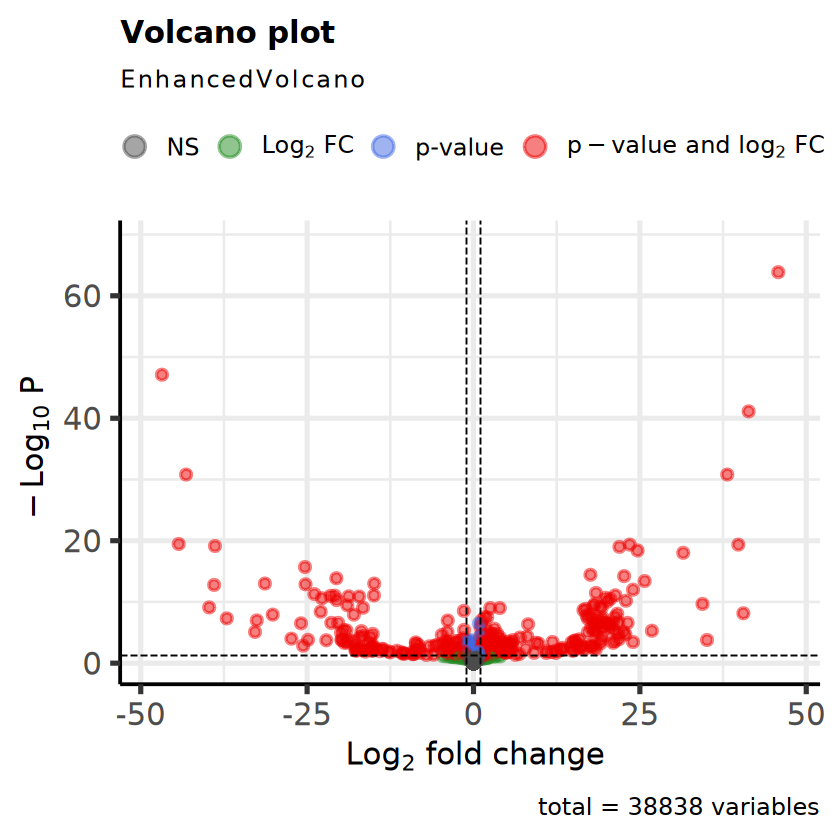

In [55]:
# H (set as control) vs. HH
res.w.cw.LFC <- lfcShrink(dds, 
                         contrast=c('complete_trtmt', 'control.warm', 'warm.NA'), 
                         type = 'ashr')

summary(res.w.cw.LFC)

EnhancedVolcano(res.w.cw.LFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [56]:
write.csv(res.w.cw.LFC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase2/deseq_res_files/p1.warm_v_p2.cont.warm.csv')

#### H vs. CH

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35466 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1078, 3%
LFC < 0 (down)     : 1621, 4.6%
outliers [1]       : 877, 2.5%
low counts [2]     : 2047, 5.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



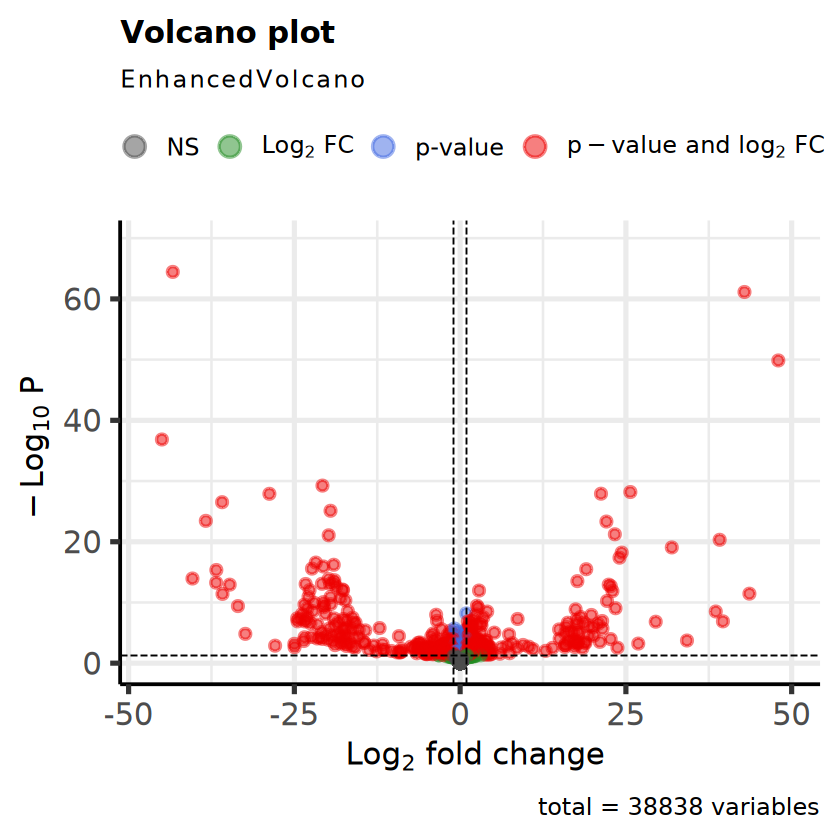

In [57]:
# H (set as control) vs. CH
res.h.ch.LFC <- lfcShrink(dds, 
                         contrast=c('complete_trtmt', 'control.hypoxic', 'hypoxic.NA'), 
                         type = 'ashr')

summary(res.h.ch.LFC)

EnhancedVolcano(res.h.ch.LFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [58]:
write.csv(res.h.ch.LFC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase2/deseq_res_files/p1.hyp_v_p2.cont.hyp.csv')

## 2.b. simultaneous stressors

### 2.b.1. early stressors when returned to control conditions
#### B vs. BC

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35466 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3301, 9.3%
LFC < 0 (down)     : 2094, 5.9%
outliers [1]       : 877, 2.5%
low counts [2]     : 2047, 5.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



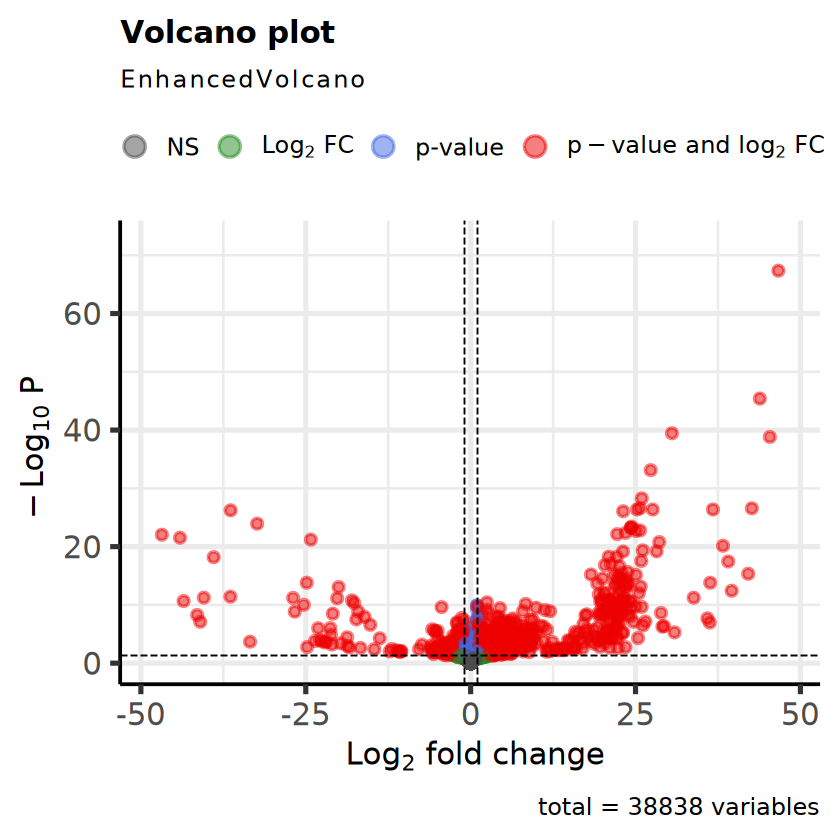

In [59]:
# H (set as control) vs. CH
res.b.bc.LFC <- lfcShrink(dds, 
                         contrast=c('complete_trtmt', 'both.control', 'both.NA'), 
                         type = 'ashr')

summary(res.b.bc.LFC)

EnhancedVolcano(res.b.bc.LFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [60]:
write.csv(res.b.bc.LFC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase2/deseq_res_files/p1.both_v_p2.both.cont.csv')

### 2.b.2. early stressors in repeated stress
#### B vs. BB

In [62]:
resultsNames(dds)

[1] "Intercept"                                  
 [2] "complete_trtmt_both.control_vs_both.both"   
 [3] "complete_trtmt_both.hypoxic_vs_both.both"   
 [4] "complete_trtmt_both.NA_vs_both.both"        
 [5] "complete_trtmt_both.warm_vs_both.both"      
 [6] "complete_trtmt_control.both_vs_both.both"   
 [7] "complete_trtmt_control.control_vs_both.both"
 [8] "complete_trtmt_control.hypoxic_vs_both.both"
 [9] "complete_trtmt_control.NA_vs_both.both"     
[10] "complete_trtmt_control.warm_vs_both.both"   
[11] "complete_trtmt_hypoxic.both_vs_both.both"   
[12] "complete_trtmt_hypoxic.control_vs_both.both"
[13] "complete_trtmt_hypoxic.hypoxic_vs_both.both"
[14] "complete_trtmt_hypoxic.NA_vs_both.both"     
[15] "complete_trtmt_hypoxic.warm_vs_both.both"   
[16] "complete_trtmt_warm.both_vs_both.both"      
[17] "complete_trtmt_warm.control_vs_both.both"   
[18] "complete_trtmt_warm.hypoxic_vs_both.both"   
[19] "complete_trtmt_warm.NA_vs_both.both"        
[20] "complete_trtmt_warm.warm_vs_both.both"

In [65]:
# H (set as control) vs. CH
res.b.bb.LFC <- lfcShrink(dds, 
                         contrast=c('complete_trtmt', 'both.NA', 'both.both'), 
                         type = 'ashr')

summary(res.b.bb.LFC)

EnhancedVolcano(res.b.bb.LFC,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

ERROR: Error in cleanContrast(object, contrast, expanded = isExpanded, listValues = listValues, : both.NA and both.both should be levels of complete_trtmt such that complete_trtmt_both.NA_vs_both.both and complete_trtmt_both.both_vs_both.both are contained in 'resultsNames(object)'


In [60]:
write.csv(res.b.bc.LFC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase2/deseq_res_files/p1.both_v_p2.both.cont.csv')